# Assignment 3 by: YourFullName (YourStudentID)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ls

A3code-Template.ipynb                 ml-1m/
A3code-Template_Part2.ipynb           s3878174-A3Code.ipynb
A3code-Tri.ipynb                      top_20_recommendations.csv
knn_test_predictions_with_titles.csv


In [3]:
cd ./ml-1m

/home/rick/Desktop/Nhat/ml-1m


In [4]:
SEP ='::'
df_u = pd.read_csv(f'users.dat', sep= SEP, names=['UserID','Gender','Age','Occupation',"Zip-code"])
df_m= pd.read_csv(f'movies.dat', sep= SEP, names=["MovieID","Title","Genres"], encoding='latin-1')
df_r = pd.read_csv(f'ratings.dat', sep= SEP, names=["UserID","MovieID","Rating","Timestamp"])


/tmp/ipykernel_228154/4021371503.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_u = pd.read_csv(f'users.dat', sep= SEP, names=['UserID','Gender','Age','Occupation',"Zip-code"])
/tmp/ipykernel_228154/4021371503.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_m= pd.read_csv(f'movies.dat', sep= SEP, names=["MovieID","Title","Genres"], encoding='latin-1')
/tmp/ipykernel_228154/4021371503.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this wa

## Preprocessing

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

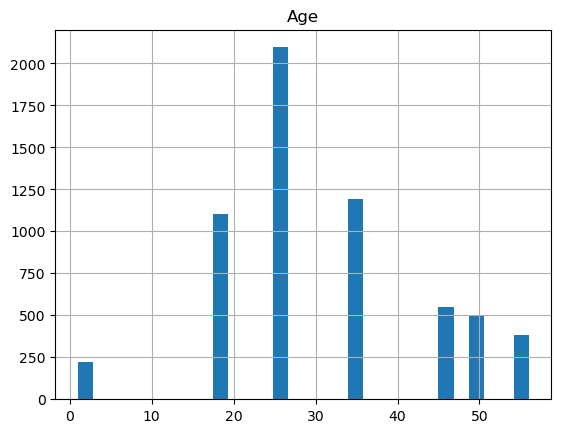

In [5]:
df_u.hist(column='Age', bins=30)

<Axes: xlabel='UserID'>

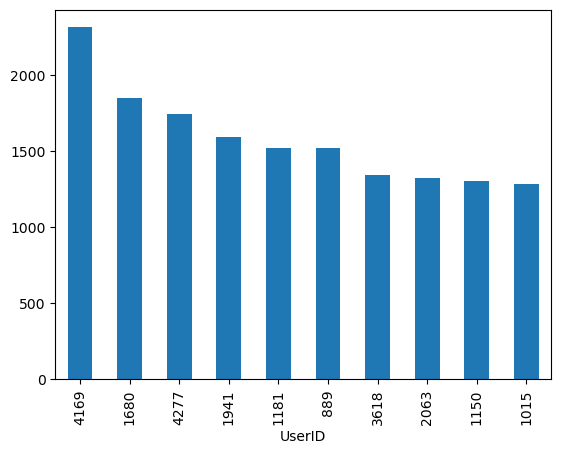

In [6]:
# Get top 10 most rating user
top_10 = df_r['UserID'].value_counts().head(10)
top_10.plot(kind='bar')


array([[<Axes: title={'center': 'Rating'}>]], dtype=object)

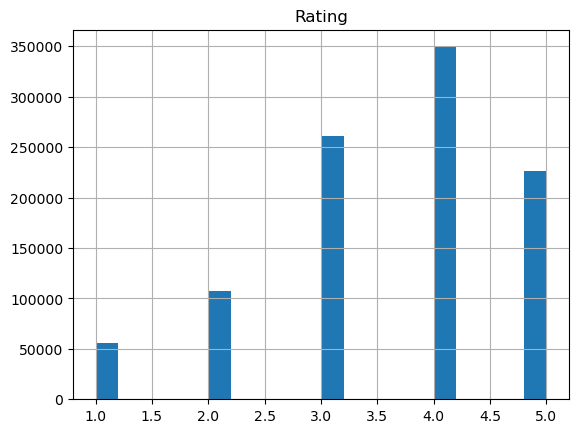

In [7]:
# Get the rating hist
df_r.hist(column='Rating', bins=20)


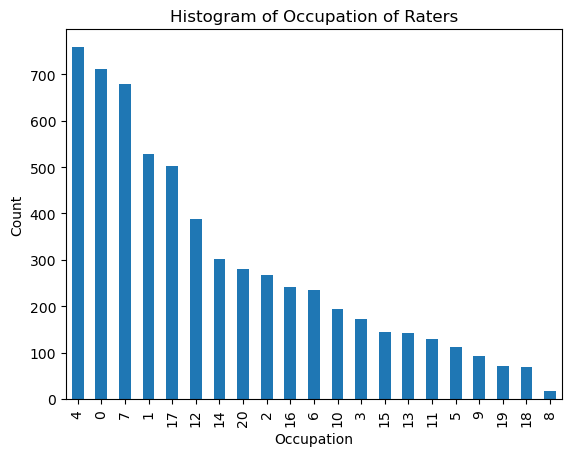

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame called df and the gender column is named 'gender'
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and modify this line to load your data

# Count the values of each gender
gender_counts = df_u['Occupation'].value_counts()

# Plot the histogram
gender_counts.plot(kind='bar')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Histogram of Occupation of Raters')
plt.show()

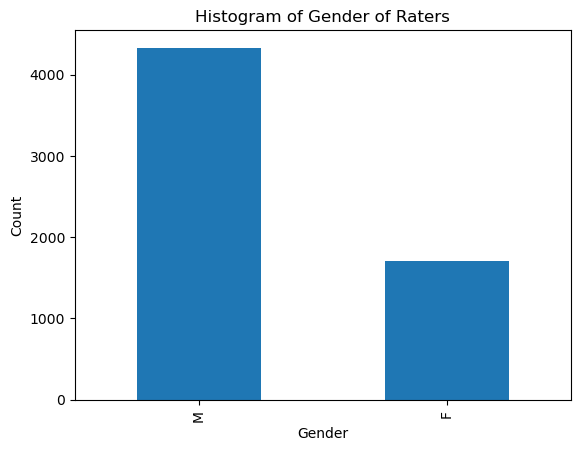

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is in a DataFrame called df and the gender column is named 'gender'
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment and modify this line to load your data

# Count the values of each gender
gender_counts = df_u['Gender'].value_counts()

# Plot the histogram
gender_counts.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Histogram of Gender of Raters')
plt.show()

<Axes: xlabel='MovieID'>

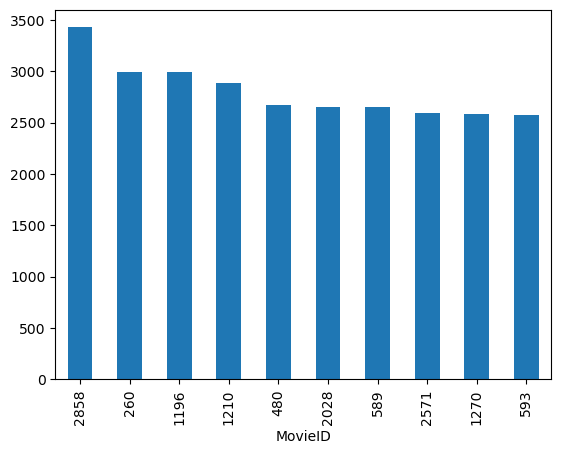

In [10]:
#Get top 10 most rating movie
top_10_movie = df_r['MovieID'].value_counts().head(10)
top_10_movie.plot(kind='bar')


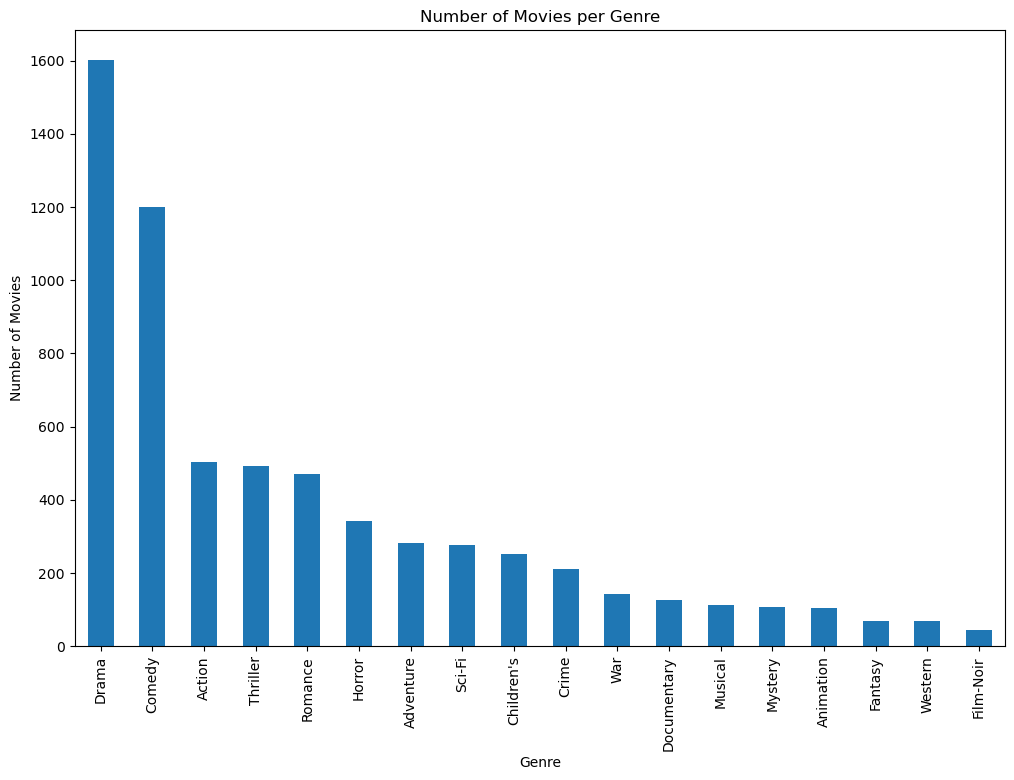

In [11]:
# Extract genres and count the occurrences
genre_counts = df_m['Genres'].str.split('|').explode().value_counts()

# Plot the genre counts
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.show()

## Preprocessing

In [12]:
# Merge all dataset, deduplicate value
df = pd.merge(df_r, df_u, on='UserID')
df = pd.merge(df, df_m, on='MovieID')
df = df.drop_duplicates()


In [13]:
#Cast correct data type
df['Rating'] = df['Rating'].astype('int')
df['Age'] = df['Age'].astype('int')
df['Occupation'] = df['Occupation'].astype('int')
df['Zip-code'] = df['Zip-code'].astype('str')


In [14]:
# Extract the year from the title
df['Year'] = df['Title'].str.extract(r'\((\d{4})\)')

In [15]:
# Convert timestamp to rating year
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['RatingYear'] = df['Timestamp'].dt.year


# Task 1: kNN-based Collaborative Filtering


In [16]:
features = ['Rating','MovieID','UserID']
df_task1 = df[features].copy()

In [17]:
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from surprise import accuracy

# Prepare the data without filling missing ratings with 0
user_movie_ratings = df_task1.pivot(index='UserID', columns='MovieID', values='Rating')

# Step 1: Apply KNN Imputer to fill missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
user_movie_ratings_filled = pd.DataFrame(imputer.fit_transform(user_movie_ratings),
                                         index=user_movie_ratings.index,
                                         columns=user_movie_ratings.columns)

# Function to apply floor rounding
def apply_floor_rounding(rating):
    """Take the integer part of the rating."""
    return np.floor(rating)

# Function to predict ratings using kNN for a given user
def predict_ratings(user_movie_ratings_filled, user_index, k, metric):
    model_knn = NearestNeighbors(metric=metric, algorithm='auto')
    
    # Step 2: Fit the KNN model using the dataframe after KNN imputation (excluding the test user)
    model_knn.fit(user_movie_ratings_filled.drop(index=user_index))
    
    # Find the k nearest neighbors for the test user
    distances, indices = model_knn.kneighbors(user_movie_ratings_filled.iloc[[user_index]], n_neighbors=k+1)
    similarities = 1 - distances.flatten()

    # Get the neighbor's ratings (valid ones)
    user_ratings = user_movie_ratings_filled.iloc[indices.flatten()[1:], :].copy()
    
    # Apply similarity-based weighted sum
    weighted_sum = np.nansum(similarities[1:, None] * user_ratings, axis=0)
    sum_of_weights = np.nansum(similarities[1:, None] * user_ratings.notna(), axis=0)

    # Predict ratings by dividing the weighted sum by the sum of weights
    with np.errstate(divide='ignore', invalid='ignore'):
        predicted_ratings = np.divide(weighted_sum, sum_of_weights, where=sum_of_weights != 0)
    predicted_ratings[sum_of_weights == 0] = np.nan

    # Apply floor rounding (take the integer part)
    final_predictions = pd.Series(predicted_ratings, index=user_movie_ratings.columns)
    final_predictions = final_predictions.apply(apply_floor_rounding)

    return final_predictions

# Randomly choose one user as the test set with random state 42
np.random.seed(42)
test_user_index = np.random.choice(user_movie_ratings.index)
true_ratings = user_movie_ratings.loc[test_user_index, :]

# Evaluate the impact of different k values and similarity metrics
k_values = [2,5,10,15,20]
similarity_metrics = ['cosine', 'manhattan']
results = {}

# Loop through all k values and similarity metrics and ensure everything is printed
for metric in similarity_metrics:
    for k in k_values:
        # Predict ratings for the test user
        predicted_ratings = predict_ratings(user_movie_ratings_filled, test_user_index, k, metric)

        # Filter out movies the test user hasn't rated (apply the same mask to true and predicted ratings)
        mask = true_ratings.notna()  # Mask to filter movies the test user has rated
        true_ratings_filtered = true_ratings[mask].values
        predicted_ratings_filtered = predicted_ratings.reindex(true_ratings.index)[mask]  # Align indices and apply mask

        # Construct the list of predictions in the format expected by Surprise's rmse
        predictions = []
        for movie_id, (true_rating, predicted_rating) in zip(true_ratings.index[mask], zip(true_ratings_filtered, predicted_ratings_filtered)):
            if not np.isnan(true_rating) and not np.isnan(predicted_rating):  # Ensure we only include valid ratings
                predictions.append((test_user_index, movie_id, true_rating, predicted_rating, None))  # Format expected by Surprise

        # Use Surprise's RMSE calculation
        rmse = accuracy.rmse(predictions, verbose=False)
        results[(metric, k)] = rmse

        # Inspect the true and predicted ratings for this user
        print(f"\nInspecting predictions for Metric: {metric}, k: {k}")
        print("True ratings (first 10):", true_ratings_filtered[:10])
        print("Predicted ratings (first 10):", predicted_ratings_filtered[:10])
        print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Output the full results for all k values and metrics
print("\nFinal RMSE Results:")
for (metric, k), rmse in results.items():
    print(f"Metric: {metric}, k: {k}, RMSE: {rmse}")

# Find the optimal k and similarity metric
optimal_metric, optimal_k = min(results, key=results.get)
print(f"\nOptimal Metric: {optimal_metric}, Optimal k: {optimal_k}, RMSE: {results[(optimal_metric, optimal_k)]}")



Inspecting predictions for Metric: cosine, k: 2
True ratings (first 10): [4. 4. 3. 3. 5. 5. 4. 3. 3. 5.]
Predicted ratings (first 10): MovieID
21      3.0
34      2.0
317     2.0
435     2.0
449     3.0
589     4.0
608     4.0
1091    2.0
1135    3.0
1220    3.0
dtype: float64
Metric: cosine, k: 2, RMSE: 1.3829316685939332

Inspecting predictions for Metric: cosine, k: 5
True ratings (first 10): [4. 4. 3. 3. 5. 5. 4. 3. 3. 5.]
Predicted ratings (first 10): MovieID
21      3.0
34      3.0
317     2.0
435     2.0
449     3.0
589     4.0
608     4.0
1091    2.0
1135    3.0
1220    3.0
dtype: float64
Metric: cosine, k: 5, RMSE: 1.3829316685939332

Inspecting predictions for Metric: cosine, k: 10
True ratings (first 10): [4. 4. 3. 3. 5. 5. 4. 3. 3. 5.]
Predicted ratings (first 10): MovieID
21      3.0
34      3.0
317     3.0
435     2.0
449     3.0
589     4.0
608     4.0
1091    2.0
1135    3.0
1220    4.0
dtype: float64
Metric: cosine, k: 10, RMSE: 1.3509256086106296

Inspecting predicti

# Task 2: Matrix Factorization-based Recommendation

In [18]:
import pandas as pd
import numpy as np
from surprise import Reader, Dataset, NMF
from surprise.model_selection import train_test_split


In [19]:
df_task2 = df.copy()
global_mean = round(df_task2['Rating'].mean())
df_task2['Rating'] = df_task2.groupby('UserID')['Rating'].transform(lambda x: x.fillna(round(x.mean())))
df_task2['Rating'].fillna(global_mean, inplace=True)


/tmp/ipykernel_228154/2963449549.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_task2['Rating'].fillna(global_mean, inplace=True)


In [20]:
test_m = df_task2['MovieID'].sample(5, random_state=42).unique()
test_df = df_task2[df_task2['MovieID'].isin(test_m)]   
train_df = df_task2[~df_task2['MovieID'].isin(test_m)]  

reader = Reader(rating_scale=(1, 5))
train_df = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
trainset = train_df.build_full_trainset()

# Step 4: Train the SVD algorithm
nmf = NMF()
nmf.fit(trainset)

# Step 5: Predict ratings for the test set
predictions = []

for _, r in test_df.iterrows():
    user = r['UserID']
    movie = r['MovieID']
    rating = r['Rating']
    
    # Predict the rating for the user-movie pair
    pred = nmf.predict(user, movie, r_ui=rating)
    predictions.append(pred)

In [21]:
# Step 6: Evaluate the model using RMSE
from surprise import accuracy
rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 1.1817
RMSE: 1.1817


## NMF + Catboost

In [22]:
df_task2 = pd.get_dummies(df_task2, columns = ['Gender'], drop_first=True)

In [23]:
df_task2.columns

Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Age', 'Occupation',
       'Zip-code', 'Title', 'Genres', 'Year', 'RatingYear', 'Gender_M'],
      dtype='object')

In [24]:
catboost_features= ['Age','Occupation','Year','Rating Year', 'Gender_M','item_latent','user_latent']

In [25]:
df_task2[features]

,Rating,MovieID,UserID
0,5,1193,1
1,3,661,1
2,3,914,1
3,4,3408,1
4,5,2355,1
...,...,...,...
1000204,1,1091,6040
1000205,5,1094,6040
1000206,5,562,6040
1000207,4,1096,6040


In [26]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, NMF
from catboost import CatBoostRegressor


r = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_task2[features], r)
train_NMF = data.build_full_trainset()

In [27]:
n_factors = 10
nmf = NMF(n_factors=n_factors)
nmf.fit(train_NMF)

In [28]:
# Extract latent features for items
def get_item_latent(x):
    try:
        return nmf.qi[trainset.to_inner_iid(x)]
    except Exception:
        return np.zeros(n_factors) 

# Extract latent features for users
def get_user_latent(x):
    try:
        return nmf.pu[trainset.to_inner_uid(x)]
    except Exception:
        return np.zeros(n_factors) 

# Apply the functions to get latent features
df_task2['item_latent'] = df_task2['MovieID'].apply(get_item_latent)
df_task2['user_latent'] = df_task2['UserID'].apply(get_user_latent)

# Display the DataFrame with the new columns
print(df_task2.head())

   UserID  MovieID  Rating           Timestamp  Age  Occupation Zip-code  \
0       1     1193       5 2000-12-31 22:12:40    1          10    48067   
1       1      661       3 2000-12-31 22:35:09    1          10    48067   
2       1      914       3 2000-12-31 22:32:48    1          10    48067   
3       1     3408       4 2000-12-31 22:04:35    1          10    48067   
4       1     2355       5 2001-01-06 23:38:11    1          10    48067   

                                    Title                        Genres  Year  \
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  1975   
1        James and the Giant Peach (1996)  Animation|Children's|Musical  1996   
2                     My Fair Lady (1964)               Musical|Romance  1964   
3                  Erin Brockovich (2000)                         Drama  2000   
4                    Bug's Life, A (1998)   Animation|Children's|Comedy  1998   

   RatingYear  Gender_M                                 

In [29]:
# i want to explode the latent features
df_task2 = df_task2.explode('item_latent')
df_task2 = df_task2.explode('user_latent')


In [30]:
df_task2

,UserID,MovieID,Rating,Timestamp,Age,Occupation,Zip-code,Title,Genres,Year,RatingYear,Gender_M,item_latent,user_latent
0,1,1193,5,2000-12-31 22:12:40,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975,2000,False,1.106892,0.403803
0,1,1193,5,2000-12-31 22:12:40,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975,2000,False,1.106892,1.088225
0,1,1193,5,2000-12-31 22:12:40,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975,2000,False,1.106892,0.188806
0,1,1193,5,2000-12-31 22:12:40,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975,2000,False,1.106892,1.381104
0,1,1193,5,2000-12-31 22:12:40,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1975,2000,False,1.106892,1.073321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000208,6040,1097,4,2000-04-26 02:19:29,25,6,11106,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,2000,True,0.733826,0.0
1000208,6040,1097,4,2000-04-26 02:19:29,25,6,11106,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,2000,True,0.733826,0.0
1000208,6040,1097,4,2000-04-26 02:19:29,25,6,11106,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,2000,True,0.733826,0.0
1000208,6040,1097,4,2000-04-26 02:19:29,25,6,11106,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,1982,2000,True,0.733826,0.0


In [31]:
# Step 1: Randomly select 5 unique movies for the test set
test_movies = df_task2['MovieID'].sample(5, random_state=42).unique()

# Step 2: Create the test set and training set
test_df = df_task2[df_task2['MovieID'].isin(test_movies)]   # Test set with selected 5 movies
train_df = df_task2[~df_task2['MovieID'].isin(test_movies)]  # Training set without the selected movies

In [32]:
train_df = train_df.dropna()
train_df = train_df.drop(columns=['Title', 'Genres', 'Timestamp', 'Zip-code'])
test_df = test_df.drop(columns=['Title', 'Genres', 'Timestamp', 'Zip-code'])
X_train = train_df.drop(columns='Rating')
y_train = train_df['Rating']
catboost_model = CatBoostRegressor(iterations=2000, learning_rate=0.01, depth=6, task_type = 'GPU')
catboost_model.fit(X_train, y_train)  # categorical features

0:	learn: 1.1167484	total: 267ms	remaining: 8m 52s
1:	learn: 1.1161852	total: 517ms	remaining: 8m 36s
2:	learn: 1.1156071	total: 768ms	remaining: 8m 31s
3:	learn: 1.1150560	total: 1.02s	remaining: 8m 28s
4:	learn: 1.1144985	total: 1.27s	remaining: 8m 26s
5:	learn: 1.1139534	total: 1.52s	remaining: 8m 25s
6:	learn: 1.1134176	total: 1.77s	remaining: 8m 24s
7:	learn: 1.1128950	total: 2.02s	remaining: 8m 23s
8:	learn: 1.1123920	total: 2.27s	remaining: 8m 22s
9:	learn: 1.1118898	total: 2.52s	remaining: 8m 21s
10:	learn: 1.1113935	total: 2.77s	remaining: 8m 21s
11:	learn: 1.1109099	total: 3.02s	remaining: 8m 21s
12:	learn: 1.1104328	total: 3.27s	remaining: 8m 20s
13:	learn: 1.1099623	total: 3.53s	remaining: 8m 20s
14:	learn: 1.1095038	total: 3.78s	remaining: 8m 19s
15:	learn: 1.1090539	total: 4.03s	remaining: 8m 19s
16:	learn: 1.1086148	total: 4.28s	remaining: 8m 19s
17:	learn: 1.1081815	total: 4.53s	remaining: 8m 18s
18:	learn: 1.1077541	total: 4.78s	remaining: 8m 18s
19:	learn: 1.1073363	t

In [33]:
X_test = test_df.drop(columns='Rating')
predictions = np.round(catboost_model.predict(X_test)).astype(int)

In [34]:
from sklearn.metrics import mean_squared_error

# Step 9: Calculate RMSE
true_ratings = test_df['Rating']  # The actual ratings in the test set
predicted_ratings = predictions  # The predicted ratings from CatBoost

# Calculate the RMSE
rmse_nmf_catboost = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

print(f"RMSE: {rmse_nmf_catboost}")

RMSE: 1.0239306879938774


# Task 3: Ranking-based Evaluation and Comparison

In [40]:
df_task3 = df_task2.copy()


In [ ]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
import numpy as np

# Define a Reader object for Surprise
reader = Reader(rating_scale=(1, 5))

# Convert the data to the Surprise format
data = Dataset.load_from_df(df_task3[['UserID', 'MovieID','Rating']], reader)

# Get users who have rated more than 100 movies
user_ratings_count = df_task3.groupby('UserID')['MovieID'].count()
eligible_users = user_ratings_count[user_ratings_count > 100].index

# Randomly select 10 users from eligible users as the test set
random_users = np.random.choice(eligible_users, size=10, replace=False)

# Split the data into training and test sets manually
train_df = df_task3[~df_task3['UserID'].isin(random_users)]  # Exclude test users from training set
test_df = df_task3[df_task3['UserID'].isin(random_users)]  # Include only the test users

# Create a lookup dictionary for MovieID -> MovieTitle
movie_id_to_title = df_task3[['MovieID', 'Title']].drop_duplicates().set_index('MovieID')['Title'].to_dict()

## KNNCF

In [ ]:

# Convert the training data into the Surprise format
train_data = Dataset.load_from_df(train_df[['UserID', 'MovieID', 'Rating']], reader)
trainset = train_data.build_full_trainset()

# Train a KNN-based collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Prepare the testset in Surprise format: list of (user_id, movie_id, actual_rating) for all users in testset
testset = [tuple(x) for x in test_df[['UserID', 'MovieID', 'Rating']].values]

# Predict ratings for the test set users (test predictions)
test_predictions = model.test(testset)

# Use the lookup dictionary to add movie titles to the predictions
predictions_list = []
for uid, iid, true_r, est, _ in test_predictions:
    movie_title = movie_id_to_title.get(iid, "Unknown Title")
    predictions_list.append({'UserID': uid, 'MovieID': iid, 'Title': movie_title, 'TrueRating': true_r, 'EstimatedRating': est})

# Convert the list to a DataFrame and save to a CSV file for later evaluation
predictions_df = pd.DataFrame(predictions_list)
predictions_df.to_csv('saved_test_predictions_with_titles.csv', index=False)

print("Test predictions saved to 'saved_test_predictions_with_titles.csv'")

# Function to get top-n recommendations for selected users based on the test predictions
def get_top_n_recommendations(predictions, n=20):
    # Map the predictions to each user
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        movie_title = movie_id_to_title.get(iid, "Unknown Title")
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, movie_title, est))

    # For each user, sort the predictions by the estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[2], reverse=True)
        top_n[uid] = [(iid, movie_title) for (iid, movie_title, _) in user_ratings[:n]]
    
    return top_n

# Get top-20 recommendations for the test set users
top_20_recommendations = get_top_n_recommendations(test_predictions, n=20)

# Display recommendations for each test user
for user, movies in top_20_recommendations.items():
    print(f"Top 20 recommendations for User {user}:")
    for movie_id, movie_title in movies:
        print(f"MovieID: {movie_id}, MovieTitle: {movie_title}")
